In [1]:
import pandas as pd
import numpy as np
from epyestim import covid19 as cv19
from datetime import datetime
from matplotlib import pyplot as plt
from functools import partial

# Load data

In [2]:
!ls ../data/

counts.csv		      OxCGRT_vaccines_full.csv
estims_all.csv		      OxCGRT_withnotes_2020.csv
OxCGRT_latest_allchanges.csv  OxCGRT_withnotes_2021.csv
OxCGRT_latest_combined.csv    OxCGRT_withnotes_2022.csv
OxCGRT_latest.csv	      population_density.csv
OxCGRT_latest_responses.csv   timeseries
OxCGRT_latest_withnotes.csv


In [3]:
cgrt = pd.read_csv('../data/OxCGRT_latest.csv', dtype={'RegionName':str, 'RegionCode': str}, 
                   parse_dates=['Date'], infer_datetime_format=True)

## Basic investigation

In [30]:
cgrt['Jurisdiction'].unique()

array(['NAT_TOTAL', 'STATE_TOTAL'], dtype=object)

In [29]:
cgrt['RegionName'][cgrt['Jurisdiction'] == 'STATE_TOTAL'].unique()

array(['Australian Capital Territory', 'New South Wales',
       'Northern Territory', 'Queensland', 'South Australia', 'Tasmania',
       'Victoria', 'Western Australia', 'Acre', 'Alagoas', 'Amazonas',
       'Amapa', 'Bahia', 'Ceara', 'Distrito Federal', 'Espirito Santo',
       'Goias', 'Maranhao', 'Minas Gerais', 'Mato Grosso do Sul',
       'Mato Grosso', 'Para', 'Paraiba', 'Pernambuco', 'Piaui', 'Parana',
       'Rio de Janeiro', 'Rio Grande do Norte', 'Rondonia', 'Roraima',
       'Rio Grande do Sul', 'Santa Catarina', 'Sergipe', 'Sao Paulo',
       'Tocantins', 'Alberta', 'British Columbia', 'Manitoba',
       'New Brunswick', 'Newfoundland and Labrador', 'Nova Scotia',
       'Northwest Territories', 'Nunavut', 'Ontario',
       'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Yukon', 'Anhui',
       'Beijing', 'Chongqing', 'Fujian', 'Guangdong', 'Gansu', 'Guangxi',
       'Guizhou', 'Henan', 'Hubei', 'Hebei', 'Hainan', 'Heilongjiang',
       'Hunan', 'Jilin', 'Jiangsu', 'Ji

In [5]:
cgrt.columns

Index(['CountryName', 'CountryCode', 'RegionName', 'RegionCode',
       'Jurisdiction', 'Date', 'C1_School closing', 'C1_Flag',
       'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag',
       'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
       'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'H6_Facial Coverings', 'H6_Flag', 'H7_Vaccination policy', 'H7_Flag',
       'H8_Protection of elderly people', 'H8_Flag', 'M1_Wildcard',
       'V1_Vaccine Prioritisation (summary)',
       'V2A_Vaccine Availability (summary)',
       'V2B_Vaccin

In [149]:
# The list of countries included
cgrt_countries = cgrt['CountryName'].unique()

In [6]:
# The number of entries for each (country, region) pair
counts = cgrt.groupby(['CountryName', 'RegionName'], dropna=False).size().reset_index().rename(columns={0:'count'})
# counts.to_csv('../data/counts.csv')

In [7]:
# Some have shorter records
counts['count'].value_counts()

869    313
503     44
Name: count, dtype: int64

In [8]:
# The regional records of Australia and India have shorter durations
# Other records all have length 869
g1 = counts[counts['count'] == 503][['CountryName', 'RegionName']].groupby(['CountryName'], dropna=False)
g2 = counts[counts['count'] == 869][['CountryName', 'RegionName']].groupby(['CountryName'], dropna=False)

In [9]:
counts[counts['CountryName'] == 'India']

,CountryName,RegionName,count
157,India,Andaman and Nicobar Islands,503
158,India,Andhra Pradesh,503
159,India,Arunachal Pradesh,503
160,India,Assam,503
161,India,Bihar,503
162,India,Chandigarh,503
163,India,Chhattisgarh,503
164,India,Dadra and Nagar Haveli and Daman and Diu,503
165,India,Delhi,503
166,India,Goa,503


In [10]:
counts[counts['CountryName'] == 'Australia']

,CountryName,RegionName,count
7,Australia,Australian Capital Territory,503
8,Australia,New South Wales,503
9,Australia,Northern Territory,503
10,Australia,Queensland,503
11,Australia,South Australia,503
12,Australia,Tasmania,503
13,Australia,Victoria,503
14,Australia,Western Australia,503
15,Australia,NaN,869


# Null values

In [31]:
cgrt.shape

(294129, 61)

In [6]:
(cgrt.isna().sum().sort_values() / cgrt.shape[0]).to_dict()

{'CountryName': 0.0,
 'CountryCode': 0.0,
 'Jurisdiction': 0.0,
 'Date': 0.0,
 'ConfirmedCases': 0.04060463266117928,
 'ConfirmedDeaths': 0.04090382111250506,
 'StringencyLegacyIndexForDisplay': 0.04127100693913215,
 'StringencyIndexForDisplay': 0.0416517922408195,
 'C1_School closing': 0.04170279027229549,
 'C2_Workplace closing': 0.0426819524766344,
 'C6_Stay at home requirements': 0.04310693607226761,
 'C3_Cancel public events': 0.043219131741514774,
 'C7_Restrictions on internal movement': 0.04322593147904491,
 'C4_Restrictions on gatherings': 0.04341972399865365,
 'C5_Close public transport': 0.04404189998266067,
 'ContainmentHealthIndexForDisplay': 0.044443084496938415,
 'StringencyLegacyIndex': 0.044609678066426635,
 'H1_Public information campaigns': 0.04489526704269215,
 'StringencyIndex': 0.04499046336811399,
 'H6_Facial Coverings': 0.045565041189410085,
 'H7_Vaccination policy': 0.047060983446038984,
 'C8_International travel controls': 0.047536965073148175,
 'ContainmentHea

In [64]:
pd.unique(cgrt[age_interval].values.ravel('K'))

array([nan, '50-54 yrs', '16-19 yrs', '5-15 yrs', '65-69 yrs',
       '75-79 yrs', '70-74 yrs', '60-64 yrs', '40-44 yrs', '55-59 yrs',
       '80+ yrs', '30-34 yrs', '20-24 yrs', '45-49 yrs', '25-29 yrs',
       '0-4 yrs', '35-39 yrs'], dtype=object)

## filling policy
+ zero or previous value: C_1-C_8, E1-2, H_1-H_8, V_1,2A,2D,2E,2F,2G,3,4
+ (-1) or previous value: C_1-C_8 flag, E_1 flag, H_ flags

## remove columns?
+ M1_Wildcard
+ stopped updating: E3_Fiscal measures, E4_International support, H4_Emergency investment in healthcare

## Special processing
+ age range to numbers / 100, 0 to 1, nan to 1: V2B, V2C

# Preprocessing (Drop columns and some transform)

TypeError: unsupported operand type(s) for +: 'DataFrameGroupBy' and 'int'

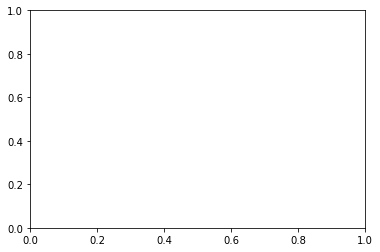

In [60]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.spy(df.groupby(['CountryName', 'RegionName'], dropna=False)[['ConfirmedCases', 'ConfirmedDeaths']].fi)
# ax.set_aspect('auto')

In [4]:
df = cgrt.drop(columns=['CountryCode', 'RegionCode', 'M1_Wildcard', 'E3_Fiscal measures', 'E4_International support',
                        'H4_Emergency investment in healthcare', 'StringencyIndex', 'StringencyIndexForDisplay',
                        'StringencyLegacyIndex', 'StringencyLegacyIndexForDisplay',
                        'GovernmentResponseIndex', 'GovernmentResponseIndexForDisplay',
                        'ContainmentHealthIndex', 'ContainmentHealthIndexForDisplay',
                        'EconomicSupportIndex', 'EconomicSupportIndexForDisplay'])
country_region = ['CountryName', 'RegionName']

In [5]:
def non_empty(df):
    b = pd.notnull(df['ConfirmedCases']).any()
    if not b:
        print(df.name)
    return b

df = df.groupby(country_region, dropna=False).filter(non_empty)

('Turkmenistan', nan)


In [6]:
def age_interval_transform(value):
    if pd.isnull(value):
        return 1
    elif '80+' in value:
        return 0.8
    else:
        return float(value.split('-',1)[0]) / 100

fillzero = ['C1_School closing',
       'C2_Workplace closing', 'C3_Cancel public events',
       'C4_Restrictions on gatherings', 'C5_Close public transport', 'C6_Stay at home requirements',
       'C7_Restrictions on internal movement', 'C8_International travel controls', 
       'E1_Income support', 'E2_Debt/contract relief', 
       'H1_Public information campaigns', 'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H5_Investment in vaccines',
       'H6_Facial Coverings', 'H7_Vaccination policy', 'H8_Protection of elderly people',
       'V1_Vaccine Prioritisation (summary)', 'V2A_Vaccine Availability (summary)',
       'V2D_Medically/ clinically vulnerable (Non-elderly)', 'V2E_Education',
       'V2F_Frontline workers  (non healthcare)', 'V2G_Frontline workers  (healthcare)',
       'V3_Vaccine Financial Support (summary)', 'V4_Mandatory Vaccination (summary)']
filln1 = ['C1_Flag', 'C2_Flag', 'C3_Flag', 'C4_Flag', 'C5_Flag', 'C6_Flag', 'C7_Flag', 'E1_Flag', 'H6_Flag',
          'H7_Flag', 'H8_Flag']
age_interval = ['V2B_Vaccine age eligibility/availability age floor (general population summary)',
       'V2C_Vaccine age eligibility/availability age floor (at risk summary)']
feat_cols = fillzero + filln1 + age_interval + ['Jurisdiction']

In [7]:
fill_dict = {k:0 for k in fillzero}
fill_dict.update({k:-1 for k in filln1})

df = df.fillna({'RegionName': '', 'RegionCode': ''})
df['Jurisdiction'] = df['Jurisdiction'].map({'NAT_TOTAL': 1, 'STATE_TOTAL': 2})
df[['ConfirmedCases', 'ConfirmedDeaths']] = (df.groupby(['CountryName', 'RegionName'], dropna=False)[['ConfirmedCases', 'ConfirmedDeaths']]
                                            .fillna(method='ffill').fillna(0))
df = df.fillna(value=fill_dict)
for c in age_interval:
    df[c] = df[c].apply(age_interval_transform)

# Taiwan

## Epiestim

In [10]:
pd.set_option('display.max_rows', 1000)
print(dfs['Taiwan'][['Date', 'ConfirmedCases']])
pd.set_option('display.max_rows', 10)

             Date  ConfirmedCases
236775 2020-01-01             0.0
236776 2020-01-02             0.0
236777 2020-01-03             0.0
236778 2020-01-04             0.0
236779 2020-01-05             0.0
236780 2020-01-06             0.0
236781 2020-01-07             0.0
236782 2020-01-08             0.0
236783 2020-01-09             0.0
236784 2020-01-10             0.0
236785 2020-01-11             0.0
236786 2020-01-12             0.0
236787 2020-01-13             0.0
236788 2020-01-14             0.0
236789 2020-01-15             0.0
236790 2020-01-16             0.0
236791 2020-01-17             0.0
236792 2020-01-18             0.0
236793 2020-01-19             0.0
236794 2020-01-20             0.0
236795 2020-01-21             0.0
236796 2020-01-22             1.0
236797 2020-01-23             1.0
236798 2020-01-24             3.0
236799 2020-01-25             3.0
236800 2020-01-26             4.0
236801 2020-01-27             5.0
236802 2020-01-28             8.0
236803 2020-01

In [11]:
taiwan = dfs['Taiwan']
taiwan = taiwan[taiwan['Date'] <= datetime.strptime("20220516", "%Y%m%d")].fillna({'ConfirmedCases': 0})
taiwan.set_index('Date', inplace=True)

In [116]:
taiwan['ConfirmedCases']

Date
2020-01-26         4.0
2020-01-27         5.0
2020-01-28         8.0
2020-01-29         8.0
2020-01-30         9.0
                ...   
2022-05-12    570870.0
2022-05-13    570870.0
2022-05-14    699824.0
2022-05-15    768543.0
2022-05-16    830257.0
Name: ConfirmedCases, Length: 842, dtype: float64

In [12]:
estim = cv19.r_covid(taiwan['ConfirmedCases'])

In [156]:
# size of the confidence intervals
pd.set_option('display.max_rows', 1000)
print(estim['Q0.975'] - estim['Q0.025'])
pd.set_option('display.max_rows', 10)

2020-01-27    0.950538
2020-01-28    0.857140
2020-01-29    0.795489
2020-01-30    0.753527
2020-01-31    0.729012
2020-02-01    0.696094
2020-02-02    0.654863
2020-02-03    0.622384
2020-02-04    0.598138
2020-02-05    0.588912
2020-02-06    0.570094
2020-02-07    0.552225
2020-02-08    0.536049
2020-02-09    0.525753
2020-02-10    0.517892
2020-02-11    0.523394
2020-02-12    0.521202
2020-02-13    0.518168
2020-02-14    0.509411
2020-02-15    0.506681
2020-02-16    0.504132
2020-02-17    0.499123
2020-02-18    0.492923
2020-02-19    0.489845
2020-02-20    0.477159
2020-02-21    0.466413
2020-02-22    0.452983
2020-02-23    0.433400
2020-02-24    0.427211
2020-02-25    0.411044
2020-02-26    0.401928
2020-02-27    0.387763
2020-02-28    0.374089
2020-02-29    0.372138
2020-03-01    0.363658
2020-03-02    0.358981
2020-03-03    0.352022
2020-03-04    0.346539
2020-03-05    0.345216
2020-03-06    0.346596
2020-03-07    0.345155
2020-03-08    0.344816
2020-03-09    0.348464
2020-03-10 

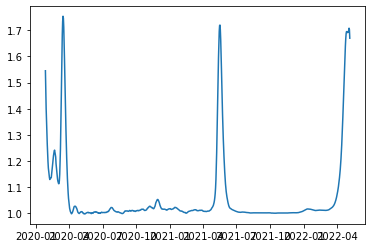

In [151]:
plt.plot(['R_mean'])

In [125]:
taiwan['ConfirmedCases'][estim.index[0]:]

Date
2020-01-27         5.0
2020-01-28         8.0
2020-01-29         8.0
2020-01-30         9.0
2020-01-31        10.0
                ...   
2022-05-12    570870.0
2022-05-13    570870.0
2022-05-14    699824.0
2022-05-15    768543.0
2022-05-16    830257.0
Name: ConfirmedCases, Length: 841, dtype: float64

In [13]:
estim

,cases,R_mean,R_var,Q0.025,Q0.5,Q0.975
2020-01-27,5.0,1.537981,0.055684,1.110554,1.525446,2.034611
2020-01-28,8.0,1.454807,0.046560,1.057947,1.444363,1.907032
2020-01-29,8.0,1.389324,0.040068,1.028669,1.379272,1.803746
2020-01-30,9.0,1.353234,0.035311,1.003977,1.343921,1.751200
2020-01-31,10.0,1.316739,0.032276,0.990929,1.309129,1.689787
...,...,...,...,...,...,...
2022-05-02,132955.0,1.691792,0.000002,1.688726,1.691792,1.694862
2022-05-03,173942.0,1.700693,0.000002,1.697820,1.700692,1.703568
2022-05-04,202418.0,1.707781,0.000002,1.705092,1.707781,1.710472
2022-05-05,232402.0,1.702303,0.000002,1.699797,1.702303,1.704811


# Find the delay for NPIs to take effect

In [110]:
def estim_R(df):
    print(df[['CountryName', 'RegionName']].iloc[0])
    df = df.copy()
    df.set_index('Date', inplace=True)
    cases = df['ConfirmedCases']
    R = cv19.r_covid(cases)
    return df.merge(R, how='inner', left_index=True, right_index=True)

feats = estims[feat_cols]
var = np.expand_dims(feats.var().to_numpy(),0)
def policy_change_delta_R(df, shift):
#     print(df['CountryName'].unique())
    feats = df[feat_cols]
    R = df['R_mean']
    policy_change = ((feats.iloc[1:-shift].values - feats.iloc[:-shift-1].values) / var).mean(axis=1)
    delta_R = R.iloc[shift+1:].values - R.iloc[1:-shift].values
#     print(delta_R.shape)
    return pd.DataFrame({'PolicyChange': policy_change, 'delta_R': delta_R})

def policy_change_dR(df, shift):
#     print(df['CountryName'].unique())
    feats = df[feat_cols]
    R = df['R_mean']
    policy_change = ((feats.iloc[1:-shift].values - feats.iloc[:-shift-1].values) / var).mean(axis=1)
    delta_R = R.iloc[shift+1:].values - R.iloc[shift:-1].values
#     assert(len(policy_change) == len(delta_R))
    return pd.DataFrame({'PolicyChange': policy_change, 'delta_R': delta_R})

In [73]:
estims = df.groupby(['CountryName', 'RegionName']).apply(estim_R)
estims = estims.reset_index(level=2).rename(columns={'level_2': 'Date'}).reset_index(drop=True)
estims.to_csv('../data/estims_all.csv', index=False)

CountryName    Afghanistan
RegionName                
Name: 869, dtype: object
CountryName    Aruba
RegionName          
Name: 0, dtype: object


In [242]:
estims = pd.read_csv('../data/estims_all.csv', index_col=[0], dtype={'RegionName':str, 'RegionCode': str}, 
                   parse_dates=['Date'], infer_datetime_format=True)
estims.fillna({'RegionName': '', 'RegionCode': ''}, inplace=True)

In [129]:
corrs1 = []
corrs2 = []

for shift in range(1,60):
    print(shift)
    delta_r = estims.groupby(country_region, group_keys=False).apply(partial(policy_change_delta_R, shift=shift))\
                .reset_index(drop=True)
    dr = estims.groupby(country_region, group_keys=False).apply(partial(policy_change_dR, shift=shift))\
                .reset_index(drop=True)
    corr1 = delta_r.corr().loc['PolicyChange','delta_R']
    corr2 = dr.corr().loc['PolicyChange','delta_R']
    corrs1.append(corr1)    
    corrs2.append(corr2)
    
corrs1 = np.array(corrs1)
corrs2 = np.array(corrs2)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


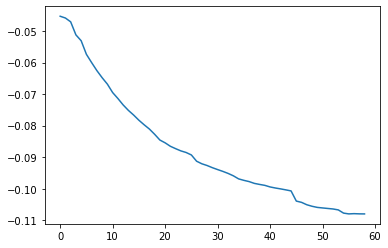

In [131]:
# delta_R
plt.plot(corrs1)

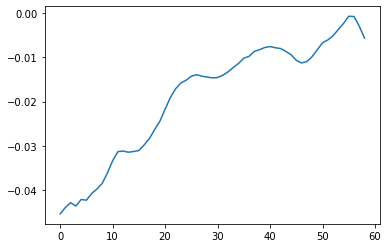

In [132]:
# dR
plt.plot(corrs2)

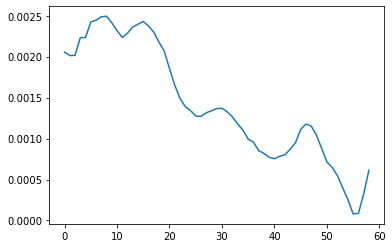

In [135]:
plt.plot(corrs1 * corrs2)

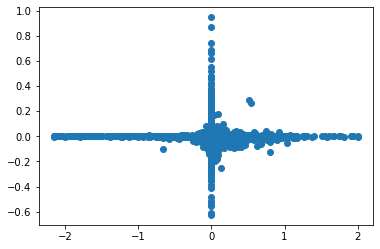

In [128]:
shift = 28
delta_r = estims.groupby(country_region, group_keys=False).apply(partial(policy_change_dR, shift=shift))\
                .reset_index(drop=True)
plt.scatter(delta_r['PolicyChange'], delta_r['delta_R'])

# Population density dataset

In [243]:
dens = pd.read_csv('../data/population_density.csv')
# Change country name for matching OxCGRT
dens.replace({
    'Ivory Coast': 'Cote d\'Ivoire',
    'DR Congo': 'Democratic Republic of Congo',
    'Republic of the Congo': 'Congo',
    'Faroe Islands': 'Faeroe Islands',
    'Kyrgyzstan': 'Kyrgyz Republic',
    'Macau': 'Macao',
    'Slovakia': 'Slovak Republic'
}, inplace=True)
dens.set_index('country', inplace=True)
dens.drop(columns=['rank', 'area', 'densityMi'], inplace=True)
handcraft = pd.DataFrame([
    [162.5, 1769.366]], 
    columns=['density', 'pop2022'], index=['Kosovo'])
dens = pd.concat([dens, handcraft])
dens.rename(columns={'density': 'PopulationDensity', 'pop2022': 'Population'}, inplace=True)

In [245]:
joined = estims.join(dens, on='CountryName')
joined.loc[joined['RegionName'] != '', ['PopulationDensity', 'Population']] = np.nan
joined.to_csv('../data/estims_all.csv', index=False)

## Look at the notes

In [4]:
# for looking at notes from OxCGRT_latest_withnotes.csv
note_cols = list(filter(lambda x: 'Note' in x, cgrt.columns))
for col in note_cols:
    print(cgrt[col][cgrt[col].notnull()])

# Convert to a list of dataframe

In [9]:
groups = df.groupby(['CountryName', 'RegionName'], dropna=False)
dfs = {}
for group, sub_df in groups:
    if pd.isnull(group[1]) or group[1] == '':
        dfs[group[0]] = sub_df
    else:
        dfs[group] = sub_df